In [1]:
from importlib import reload
import os
import pandas as pd
from io import StringIO
import itertools
import ipdb
import datetime
from collections import Counter

import h5py
import json
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib
print(tf.__version__)

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM

from keras.callbacks import EarlyStopping
from tensorflow.compat.v1.losses import sparse_softmax_cross_entropy

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import mytf.s3utils as msu
import mytf.utils as mu
import mytf.validation as mv
import mytf.plot as mp

1.14.0


Using TensorFlow backend.


In [4]:
test1M = msu.s3_csv_to_df(bucket_name='my-sagemaker-blah',
                 s3_filename='aviation/test.first1M.csv')



In [5]:
test1M.shape

(999999, 28)

In [7]:
test1M.crew.value_counts()

1    999999
Name: crew, dtype: int64

In [8]:
test1M.iloc[0]

id                   0
crew                 1
experiment        LOFT
time                 0
seat                 0
eeg_fp1        17.8995
eeg_f7         6.12783
eeg_f8        0.994807
eeg_t4        -28.2062
eeg_t6        -47.6955
eeg_t5         -187.08
eeg_t3        -33.1835
eeg_fp2       -4.22078
eeg_o1         8.17816
eeg_p3         33.1603
eeg_pz         33.8125
eeg_f3         21.7447
eeg_fz         16.2938
eeg_f4        -7.04448
eeg_c4        -14.4051
eeg_p4        -4.03384
eeg_poz      -0.393799
eeg_c3         31.8381
eeg_cz         17.0756
eeg_o2        -8.13735
ecg           -7323.12
r              643.177
gsr            594.779
Name: 0, dtype: object

In [9]:
test1M.seat.value_counts()

0    500000
1    499999
Name: seat, dtype: int64

In [10]:
test1M.experiment.value_counts()

LOFT    999999
Name: experiment, dtype: int64

In [11]:
test1M[['id', 'time', 'seat', 'eeg_fp1', 'ecg', 'r', 'gsr']].iloc[:10]

,id,time,seat,eeg_fp1,ecg,r,gsr
0,0,0.000000,0,17.899500,-7323.120117,643.177002,594.778992
1,1,0.000000,1,45.883202,-3335.080078,826.724976,136.235001
2,2,0.003906,0,33.120098,-7323.120117,643.177002,594.778992
3,3,0.003906,1,43.280102,-3335.080078,826.724976,136.235001
4,4,0.007812,0,7.929110,-7323.120117,643.177002,594.778992
5,5,0.007812,1,30.535999,-3335.080078,826.724976,136.235001
6,6,0.011719,0,17.369301,-7323.120117,643.177002,594.778992
7,7,0.011719,1,33.028599,-3335.080078,826.724976,136.235001
8,8,0.015625,0,14.567900,-7323.120117,643.177002,594.778992
9,9,0.015625,1,37.561600,-3335.080078,826.724976,136.235001


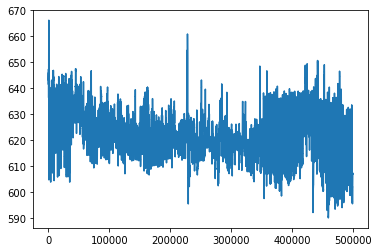

In [12]:
plt.plot(test1M[test1M.seat == 0].r.tolist())

In [13]:
timevec = test1M[test1M.seat == 0].time.tolist()
print(sorted(timevec) == timevec)

False


In [15]:
(list(zip(sorted(timevec), timevec))[:20])

[(0.0, 0.0),
 (0.00390625, 0.00390625),
 (0.0078125, 0.0078125),
 (0.01171875, 0.01171875),
 (0.015625, 0.015625),
 (0.01953125, 0.01953125),
 (0.0234375, 0.0234375),
 (0.02734375, 0.02734375),
 (0.03125, 0.03125),
 (0.03515625, 0.03515625),
 (0.0390625, 0.0390625),
 (0.04296875, 0.04296875),
 (0.046875, 0.046875),
 (0.05078125, 0.05078125),
 (0.0546875, 0.0546875),
 (0.05859375, 0.05859375),
 (0.0625, 0.0625),
 (0.06640625, 0.06640625),
 (0.0703125, 0.0703125),
 (0.07421875, 0.07421875)]

In [17]:
len([x for x in list(zip(sorted(timevec), timevec))
    if x[0] != x[1]]), len(timevec)

(497920, 500000)

In [18]:
for i, x in enumerate(list(zip(sorted(timevec), timevec))):
    if x[0] != x[1]:
        print(i, x[0], x[1])
        break

512 2.0 10.0


In [20]:
list(zip(sorted(timevec), timevec))[510:520]

[(1.9921875, 1.9921875),
 (1.99609375, 1.99609375),
 (2.0, 10.0),
 (2.00390625, 10.00390625),
 (2.0078125, 10.0078125),
 (2.01171875, 10.01171875),
 (2.015625, 10.015625),
 (2.01953125, 10.01953125),
 (2.0234375, 10.0234375),
 (2.02734375, 10.02734375)]

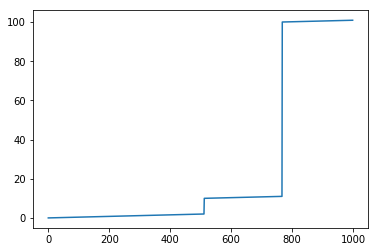

In [26]:
plt.plot(test1M[test1M.seat == 0].time.tolist()[:1000], label='0')

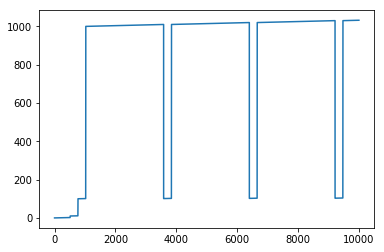

In [27]:
# What the hell is that? 
plt.plot(test1M[test1M.seat == 0].time.tolist()[:10000], label='0')

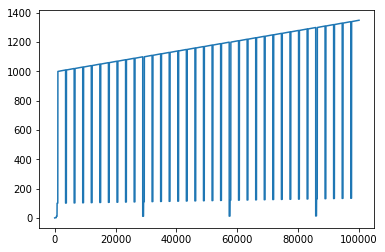

In [28]:
plt.plot(test1M[test1M.seat == 0].time.tolist()[:100000], label='0')

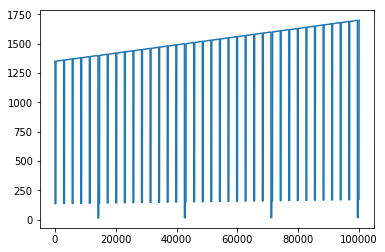

In [29]:
plt.plot(test1M[test1M.seat == 0].time.tolist()[100000:200000], label='0')

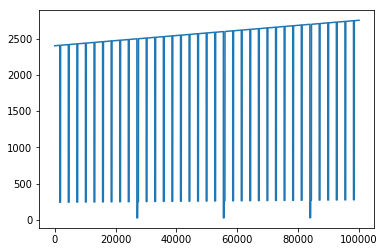

In [30]:
plt.plot(test1M[test1M.seat == 0].time.tolist()[-100000:], label='0')

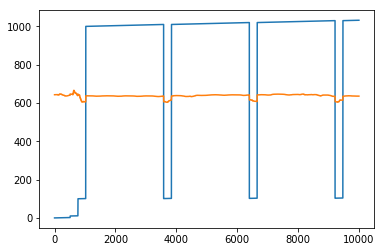

In [31]:
# Yea wtf, based on this, even the data itself is showing that shit is abnormal
plt.plot(test1M[test1M.seat == 0].time.tolist()[:10000], label='t')
plt.plot(test1M[test1M.seat == 0].r.tolist()[:10000], label='r')

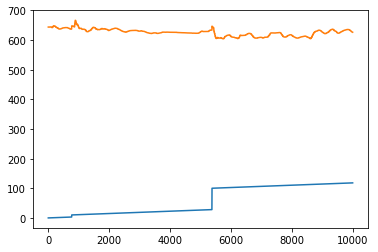

In [34]:
sortedTestDf = test1M.sort_values(by=['time']).copy()
# test1M.sort_values?
plt.plot(sortedTestDf[sortedTestDf.seat == 0].time.tolist()[:10000], label='t')
plt.plot(sortedTestDf[sortedTestDf.seat == 0].r.tolist()[:10000], label='r')

In [33]:
# ok but this is true, so basically what the fack? It indicates that time was what going backwards haha?
# Or time is not what we think it is ? hahaha! even crazier. 
sorted(test1M['id'].tolist()) == test1M['id'].tolist()

True

In [40]:
# Okay but it is good that there are no duplicates in the time, per the below.
# So I think it is safe to assume I can sort the data, run predictions separately for seat=0 and seat=1 ,
# then the predictions need to be resorted by the original index column again . 
print(test1M[test1M.seat == 0].time.unique().shape == test1M[test1M.seat == 0].time.shape)
print(test1M[test1M.seat == 1].time.unique().shape == test1M[test1M.seat == 1].time.shape)



True
True


#### Preprocess
Ok dang but the preprocessing might be difficult if the time jumps really globally and not locally.
What are the biggest jumps in there. is the first 1million missing ? Visually it does look like it is missing a lot.


In [46]:
set(test1M[test1M.seat == 0].time.tolist()[:-1]) -  set(test1M[test1M.seat == 1].time.tolist())

set()

In [45]:
test1M[test1M.seat == 0].time.tolist()[-1]

2756.12109375

In [47]:
(test1M[test1M.seat == 0].time.tolist()[:-1]) ==  (test1M[test1M.seat == 1].time.tolist())

True

In [48]:
test1M[test1M.seat == 0].time.tolist()[:5]

[0.0, 0.00390625, 0.0078125, 0.01171875, 0.015625]

In [49]:
1/256

0.00390625

In [54]:
len(np.arange(0, 2756, 1/256)), 2756*256

(705536, 705536)

In [55]:
# Ah shit. so yea indeed a lot of holes... 
len(set(np.arange(0, 2756, 1/256)) - set(test1M[test1M.seat == 0].time.tolist()[:-1]))

205568

In [56]:
list(set(np.arange(0, 2756, 1/256)) - set(test1M[test1M.seat == 0].time.tolist()[:-1]))[:10]

[3.00390625,
 3.0078125,
 3.0,
 3.01171875,
 3.67578125,
 4.0,
 4.00390625,
 4.0078125,
 4.01171875,
 4.81640625]

#### so indeed need to likely sort across the whole dataset .
Also the test dataset has a few non informative columns.. at least can use awk to remove them..
( Esp. per this cool [article](https://www.tim-dennis.com/data/tech/2016/08/09/using-awk-filter-rows.html) )

```bash
(pandars3) $ head -5 data/test.csv | awk -F ',' '{print $1,",",$2, $3, $4, $5}'
id , crew experiment time seat
0 , 1 LOFT 0.00000000 0
1 , 1 LOFT 0.00000000 1
2 , 1 LOFT 0.00390625 0
3 , 1 LOFT 0.00390625 1

(pandars3) $ head -5 data/test.csv | awk -F ',' '{print $1,",", $4, ",", $5}'
id , time , seat
0 , 0.00000000 , 0
1 , 0.00000000 , 1
2 , 0.00390625 , 0
3 , 0.00390625 , 1
```

Or also I can use awk to treat seat=0 and seat=1 separately...

```bash
(pandars3) $ awk -F ',' '{if ( $5 == 0) {print $1,",", $4, ",", $5}}' data/test.csv |head -10
0 , 0.00000000 , 0
2 , 0.00390625 , 0
4 , 0.00781250 , 0
6 , 0.01171875 , 0
8 , 0.01562500 , 0
10 , 0.01953125 , 0
12 , 0.02343750 , 0
14 , 0.02734375 , 0
16 , 0.03125000 , 0
18 , 0.03515625 , 0
```


#### sort 
ok..

```bash
awk -F ',' '{if ( $5 == 0) {print $1,",", $4, ",", $5}}' data/test.csv |head -10 | sort -t',' -k2n,2 -r
```

Ok but the space separater was clashing with the unix `sort` .. so instead..

```bash
(pandars3) $ awk -F ',' 'BEGIN {OFS = "" } {if ( $5 == 0) {print $1,",", $4, ",", $5}}' data/test.csv |head -5
0,0.00000000,0
2,0.00390625,0
4,0.00781250,0
6,0.01171875,0
8,0.01562500,0

```

#### try sort again,,

```bash
awk -F ',' 'BEGIN {OFS = "" } {if ( $5 == 0) {print $1,",", $4, ",", $5}}' data/test.csv \
        |head -5 \
        | sort -t ',' -k2n,2 -r
```
Hmm still didnt quite seem to work, but probably because numeric doesnt work on floats!?

```bash
(pandars3) $ awk -F ',' 'BEGIN {OFS = "" } {if ( $5 == 0) {print $1,",", $4, ",", $5}}' data/test.csv         |head -5         | sort -t',' -k2n,2 -r
0,0.00000000,0
2,0.00390625,0
4,0.00781250,0
6,0.01171875,0
8,0.01562500,0
(pandars3) $ awk -F ',' 'BEGIN {OFS = "" } {if ( $5 == 0) {print $1,",", $4, ",", $5}}' data/test.csv         |head -5         | sort -t',' -k2,2 -r
8,0.01562500,0
6,0.01171875,0
4,0.00781250,0
2,0.00390625,0
0,0.00000000,0
```

#### hmm i think this is working... 
```bash
awk -F ',' 'BEGIN {OFS = "" } {if ( $5 == 0) {print $1,",", $4, ",", $5}}' data/test.csv \
        |head -5 \
        | sort -t ',' -k2,2 -r --numeric-sort
```

#### wow even works with negatives
```bash
(pandars3) $ awk -F ',' 'BEGIN {OFS = "," } {if ( $5 == 0 || $5 == "seat") {print $1, $4, $5, $6}}' data/test.csv|head | sort -t "," -k 4,4 --numeric-sort
12,0.02343750,0,-25.6259
14,0.02734375,0,-10.3334
16,0.03125000,0,-0.736422
id,time,seat,eeg_fp1
10,0.01953125,0,0.487288
4,0.00781250,0,7.92911
8,0.01562500,0,14.5679
6,0.01171875,0,17.369301
0,0.00000000,0,17.8995
2,0.00390625,0,33.120098
```


#### Going all the way..

```bash
awk -F ',' 'BEGIN {OFS = "," } {if ( $5 == 0 || $5 == "seat") {print $1, $4, $5, $6}}' data/test.csv \
        | sort -t ',' -k 2,2  --numeric-sort  > data/test-seats-eegfp1.csv
```

* Okay so `sort` on my laptop varied between `1.7g` and `2.3g` , so yea I guess in memory sort indeed.

```bash
(pandars3) $ time awk -F ',' 'BEGIN {OFS = "," } {if ( $5 == 0 || $5 == "seat") {print $1, $4, $5, $6}}' data/test.csv \
>         | sort -t ',' -k 2,2  --numeric-sort  > data/test-seats-eegfp1.csv

real	6m13.695s
user	6m4.894s
sys	0m10.971s
(pandars3) $ 

```
* If I involve all the columns I need, hmm I wonder if I end up running out of memory.

#### oh also crap, i guess there were multiple crews in there after all? 

```bash
(pandars3) $ less data/test-seats-eegfp1.csv

0,0.00000000,0,17.8995
2075595,0.00000000,0,170.852005
4592477,0.00000000,0,12.8333
id,time,seat,eeg_fp1
10580113,0.00390625,0,-50.842499
2,0.00390625,0,33.120098
2075598,0.00390625,0,179.259003
4592478,0.00390625,0,2.28976
10580114,0.00781250,0,-33.115501
16110215,0.00781250,0,-3.9552
2075600,0.00781250,0,170.884003
4,0.00781250,0,7.92911
4592479,0.00781250,0,-14.4628

```
* Aha...
```bash
(pandars3) $ awk -F ',' 'BEGIN {OFS = ","} {if ($2 != 1) print $1,$2,$3,$4,$5 }' data/test.csv |head -5 
id,crew,experiment,time,seat
2075595,2,LOFT,0.00000000,0
2075596,2,LOFT,0.00000000,1
2075597,2,LOFT,0.00300000,1
2075598,2,LOFT,0.00390625,0
(pandars3) $
```
* That's actually kind of good. It works to my advantage in that those 18million rows can be nicely split out into not perhaps 4 or 5 crews of 2 seats each or so, so sorting larger sets in memory will be that much more feasible!

```bash
(pandars3) $ time awk -F ',' '{print $2}' data/test.csv|uniq
crew
1
2
3
4
5
6
7
8
13

real	5m22.960s
user	5m24.085s
sys	0m4.936s
```

#### Ok.. so going to make the several separate datasets then... and sort them later

```bash
for i in 1 2 3 4 5 6 7 8 13; 
   do 
   for j in 0 1 ; 
     do 
     outfile="data/test-crew-${i}_seat-${j}.csv"
     echo Starting ${outfile} $(date)
     
     awk -v crew=${i} -v seat=${j} \
              -F ',' 'BEGIN {OFS = "," } \
                      {if (($5 == seat || $5 == "seat") \
                          && ($2 == crew || $2 == "crew")) \
                      {print $0 } } \
                      ' data/test.csv \
         | sort -t ',' -k 2,2  --numeric-sort  >  ${outfile} 
     done 
   done


 head data/test.csv | awk -v crew=4,seat=1 '{print "hello" "crew" crew "seat" seat }' 

```


##### Output from running the above

```bash

Starting data/test-crew-1_seat-0.csv Sun Mar 8 20:40:10 EDT 2020
Starting data/test-crew-1_seat-1.csv Sun Mar 8 20:46:13 EDT 2020
Starting data/test-crew-2_seat-0.csv Sun Mar 8 20:52:14 EDT 2020
Starting data/test-crew-2_seat-1.csv Sun Mar 8 20:58:29 EDT 2020
Starting data/test-crew-3_seat-0.csv Sun Mar 8 21:04:44 EDT 2020
Starting data/test-crew-3_seat-1.csv Sun Mar 8 21:10:49 EDT 2020
Starting data/test-crew-4_seat-0.csv Sun Mar 8 21:17:03 EDT 2020
Starting data/test-crew-4_seat-1.csv Sun Mar 8 21:23:10 EDT 2020
Starting data/test-crew-5_seat-0.csv Sun Mar 8 21:29:08 EDT 2020
Starting data/test-crew-5_seat-1.csv Sun Mar 8 21:35:24 EDT 2020
Starting data/test-crew-6_seat-0.csv Sun Mar 8 21:41:34 EDT 2020
Starting data/test-crew-6_seat-1.csv Sun Mar 8 21:47:38 EDT 2020
Starting data/test-crew-7_seat-0.csv Sun Mar 8 21:53:44 EDT 2020
Starting data/test-crew-7_seat-1.csv Sun Mar 8 21:59:46 EDT 2020
Starting data/test-crew-8_seat-0.csv Sun Mar 8 22:05:46 EDT 2020
Starting data/test-crew-8_seat-1.csv Sun Mar 8 22:11:49 EDT 2020
Starting data/test-crew-13_seat-0.csv Sun Mar 8 22:17:55 EDT 2020
Starting data/test-crew-13_seat-1.csv Sun Mar 8 22:23:49 EDT 2020
```




### 2020-03-15

#### Ah crap, after that ^^ ... I sorted by the old sort key oops. 

```python
In [2]: df = pd.read_csv('data/test-crew-1_seat-0.csv')

In [37]: df[['id', 'time']].iloc[:10]                                                           
Out[37]: 
        id         time
0        0     0.000000
1       10     0.019531
2      100     0.195312
3     1000     1.953125
4    10000  1014.531250
5   100000  1173.312500
6  1000000  2756.125000
7  1000002  2756.128906
8  1000004  2756.132812
9  1000006  2756.136719

In [38]: df.time.tolist() == sorted(df.time.tolist())                                           
Out[38]: False
    
```

So when instead I tried ..

```bash
(pandars3) $ cat data/test-crew-1_seat-0.csv | sort -t ',' -k 4,4  --numeric-sort > data/test-crew-1_seat-0.sorted.csv

```
The only thing the header row is the 2nd row for some reason. so skipped row1 and..

```python
In [43]: df2 = pd.read_csv('data/test-crew-1_seat-0.sorted.csv', skiprows=1)                              

In [44]: df2.time.tolist() == sorted(df2.time.tolist())                                                   
Out[44]: True

```



#### And seeming like time steps are showing the rows at least for crew1, seat0, are continguous

```python

In [118]: df2['time2'] = df2.time.shift()                                                                 

In [119]: df2[['id', 'time', 'time2']].iloc[:10]                                                          
Out[119]: 
   id      time     time2
0   2  0.003906       NaN
1   4  0.007812  0.003906
2   6  0.011719  0.007812
3   8  0.015625  0.011719
4  10  0.019531  0.015625
5  12  0.023438  0.019531
6  14  0.027344  0.023438
7  16  0.031250  0.027344
8  18  0.035156  0.031250
9  20  0.039062  0.035156

In [120]: df2.apply(lambda x: x.time - x.time2, axis=1).unique().shape                                    
Out[120]: (2,)

```


#### Today
- so today I wrote up to commit `5cc128` , building overlapped, index aware, unlabelled data
- Did some general QA and the `make_test_data` func roughly seems functional.
- This basically is the first time I'm applying the window funcs on data where the output label is missing
- And I had been ignoring the index this whole time as well haha. So I needed to add taht as well.


#### for now still just testing out locally  ..
```python
# locally the scaler is ...
# scaler = joblib.load('history/2020-02-02T044441Z/scalers.joblib')

# copied to s3 also so I can do a quick qa on laptop...
# (tensorflow_p36) $ aws s3 cp ./history/2020-02-02T044441Z/scalers.joblib s3://mybucket/aviation/history/2020-02-02T044441Z/scalers.joblib
upload: history/2020-02-02T044441Z/scalers.joblib to s3://mybucket/aviation/history/2020-02-02T044441Z/scalers.joblib
```

* `8` Feature cols currently using as per [earlier notebook](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-21--update.md)

```python
cols = ['r', 'ecg', 'gsr', 
        'eeg_fp1','eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', ]
```

```python
In [43]: df2 = pd.read_csv('data/test-crew-1_seat-0.sorted.csv', skiprows=1)                              

In [206]: featurecols = ['r', 'ecg', 'gsr',  
     ...:         'eeg_fp1','eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', ]                                                 

In [207]: %%time 
     ...: ipdb.runcall(mu.make_test_data, df2, 
     ...:             window_size=64, 
     ...:             row_batch_size=10000, 
     ...:             feature_cols=featurecols, 
     ...:             save_dir=outdir) 
     ...:                                                                                                 
> /Users/michal/LeDropbox/Dropbox/Code/Kaggle/reducing-commercial-aviation-fatalities/mytf/utils.py(540)make_test_data()
    539     # keep_index; and option for overlap.
--> 540     _ = get_windows_h5(df,
    541                        cols=['id'] + feature_cols, # + ['event'],

ipdb> c                                                                                                   
CPU times: user 17.5 s, sys: 3.44 s, total: 21 s
Wall time: 31.1 s
```

#### Want to applyl scalers next .. 
* Below using `finalloc = ('data/2020-03-15T2032Z/finaltest.h5')`  because I had hard coded `finaltest.h5` into the `make_test_data` func.

```python
import joblib
workdir = 'data/2020-03-15T2032Z'
finalloc = f'{workdir}/finaltest.h5'
mu.apply_scalers(finalloc, 
               datasets=[x for x in mu.h5_keys(testloc) 
                           if '_X' in x],
               scaler=scaler,
               outloc=f'{workdir}/finaltest_scaled.h5')
```


```python
In [211]: finalloc = ('data/2020-03-15T2032Z/finaltest.h5') 
     ...: #IX = mu.read_h5_raw(finalloc, 'dataset_0_IX') 
     ...: #X = mu.read_h5_raw(finalloc, 'dataset_0_X') 
     ...: workdir = ('data/2020-03-15T2032Z')                                                             


```

But ...

```python

In [212]: %%time 
     ...: mu.apply_scalers(finalloc,  
     ...:                datasets=[x for x in mu.h5_keys(finalloc)  
     ...:                            if '_X' in x], 
     ...:                scaler=scalers, 
     ...:                outloc=f'{workdir}/finaltest_scaled.h5' 
     ...:  
     ...:                   ) 
     ...:                                                                                                 
  0%|                                                                             | 0/105 [00:00<?, ?it/s]
---------------------------------------------------------------------------
ValueError                                Traceback (most recent call last)
<timed eval> in <module>

~/.../mytf/utils.py in apply_scalers(loc, datasets, scaler, outloc)
    922         Xss = np.reshape(scaler.transform(
    923             np.reshape(X,
--> 924                        (fullsize, X.shape[2]))),
    925                          original_shape)
    926 

/usr/local/miniconda3/envs/pandars3/lib/python3.7/site-packages/sklearn/preprocessing/data.py in transform(self, X)
    385                         force_all_finite="allow-nan")
    386 
--> 387         X *= self.scale_
    388         X += self.min_
    389         return X

ValueError: operands could not be broadcast together with shapes (635968,7) (8,) (635968,7) 

In [213]: X = mu.read_h5_raw(finalloc, 'dataset_0_X')                                                     

In [214]: X.shape                                                                                         
Out[214]: (9937, 64, 7)

In [215]: len(featurecols)                                                                                
Out[215]: 8

In [216]: print(featurecols)                                                                              
['r', 'ecg', 'gsr', 'eeg_fp1', 'eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6']


```


### 2020-03-21

#### got to fix that bad shape somehow... 
* Ah ok oops. had a bug in the `_inner_get_windows` func..  Fixing in commit `bb77d33`.
* Also realized since just from 1 out of 18 test files I had created, since it was `3.5G` , I cant  throw `18` datasets in there. 
* Instead, just got to do one piece at a time. Part of the predict pipeline I suppose... Delete/overwrite each time.
* Perhaps I can just jam that into `predict.py` , as an update.

```
import joblib
import pandas as pd
df2 = pd.read_csv('data/test-crew-1_seat-0.sorted.csv', skiprows=1)                              

featurecols = ['r', 'ecg', 'gsr',  
              'eeg_fp1','eeg_f7', 'eeg_f8', 'eeg_t4', 'eeg_t6', ]                                                 
workdir = 'data/2020-03-15T2032Z'

%%time
mu.make_test_data(df2, 
            window_size=64, 
            row_batch_size=10000, 
            feature_cols=featurecols, 
            save_dir=workdir)
# ==> In [236]:
# Wall time: 29.9 s


finalloc = f'{workdir}/finaltest.h5'

# In [239]: len([x for x in mu.h5_keys(finalloc)  
#                                 if '_X' in x])                                                       
# Out[239]: 105


# Got this message locally too... hopefully for now its ok..
# After testing this flow locally I want to do the whole thing in cloud...
# 
scalers = joblib.load('history/2020-02-02T044441Z/scalers.joblib')
/usr/local/miniconda3/envs/pandars3/lib/python3.7/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator MinMaxScaler from version 0.21.3 when using version 0.20.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)

# Look at time just for one ... 
%%time
mu.apply_scalers(finalloc, 
               datasets=[x for x in mu.h5_keys(finalloc) 
                           if '_X' in x][:1],
               scaler=scalers,
               outloc=f'{workdir}/finaltest_scaled.h5')
# => Wall time: 312 ms
# Ok so its still pretty cheap..

# Quick validation .. 
In [246]: X = mu.read_h5_raw(finalloc, 'dataset_0_X')                                                     

In [247]: Xs = mu.read_h5_raw(f'{workdir}/finaltest_scaled.h5', 'dataset_0_X_scaled')                     

In [248]: X.shape, Xs.shape                                                                               
Out[248]: ((9937, 64, 8), (9937, 64, 8))

In [249]: X[:1,:1,:]                                                                                      
Out[249]: 
array([[[ 6.43177002e+02, -7.32312012e+03,  5.94778992e+02,
          3.31200980e+01,  2.83565010e+01, -7.23922000e+00,
         -7.69086000e+00, -2.58337990e+01]]])

In [250]: Xs[:1,:1,:]                                                                                     
Out[250]: 
array([[[-0.00865528,  0.37437108,  0.29741032,  0.58548244,
          0.58233324,  0.58615207,  0.59763897,  0.56314214]]])


```
* Ok, validation looks good...
* Also obviously not scaling the index, but I can just re-use the index data from the original `finaltest.h5` I suppose. Or copy over, to make that code simpler, so dont have to specify multiple files in predict? 

#### Indices... hmm
* This looks weird though. Why not overlapping though? Grr..

```python

In [251]: IX1 = mu.read_h5_raw(finalloc, 'dataset_1_IX')                                                  

In [252]: IX0 = mu.read_h5_raw(finalloc, 'dataset_0_IX')                                                  

In [253]: IX0.shape, IX1.shape                                                                            
Out[253]: ((9937,), (9937,))

In [254]: len(set(IX0))                                                                                   
Out[254]: 9937

In [255]: len(set(IX0) & set(IX1))                                                                        
Out[255]: 1

In [256]: set(IX0) & set(IX1)                                                                             
Out[256]: {1650208.0}

In [257]: IX2 = mu.read_h5_raw(finalloc, 'dataset_2_IX')                                                  

In [258]: len(set(IX1) & set(IX2))                                                                        
Out[258]: 1

In [259]: set(IX1) & set(IX2)                                                                             
Out[259]: {1945483.0}

In [260]: IX3 = mu.read_h5_raw(finalloc, 'dataset_3_IX')                                                  

In [261]: set(IX2) & set(IX3)                                                                             
Out[261]: {92512.0}


```

* ok... made changes to `predict.py`  , going to test them out... 
* Running locally .. 

```bash
time python predict.py --test-loc data/2020-03-15T2032Z/finaltest_scaled.h5 \
        --batch-size 1024 \
        --model-loc history/2020-02-16T035758Z/epoch_001_batch_01760_model.h5 \
        --work-dir data/2020-03-15T2032Z \
        --eager     
```


### 2020-03-22

#### And let the predict script publish results

* From [previous notebook](https://github.com/namoopsoo/aviation-pilot-physiology-hmm/blob/master/notes/2019-12-21--update.md#apply-and-transfer)

```python
workdir = 'data/2020-03-15T2032Z'
finalloc = f'{workdir}/finaltest.h5'
finalscaledloc = f'{workdir}/finaltest_scaled.h5'

mu.transfer(source_location=finalloc, 
            source_datasets=[x for x in mu.h5_keys(finalloc) 
                               if '_IX' in x], 
            save_location=finalscaledloc)


In [282]: len([mu.read_h5_raw(finalscaledloc,  x) for x in  
     ...:                                     mu.h5_keys(finalloc)   if '_IX' in x]) 
     ...:                                                                                                 
Out[282]: 105
```

#### and ok not much overlap but anyway thats fine 

```python
In [283]: np.concatenate([mu.read_h5_raw(finalscaledloc,  x) for x in  
     ...:                                     mu.h5_keys(finalloc)   if '_IX' in x]).shape                
Out[283]: (1037828,)

In [284]: len(set(np.concatenate([mu.read_h5_raw(finalscaledloc,  x) for x in  
     ...:                                     mu.h5_keys(finalloc)   if '_IX' in x])))                    
Out[284]: 1037724
```

```python
joblib.Parallel(n_jobs=-1,
                backend='multiprocessing',
                verbose=10)
                
from time import sleep
from joblib import Parallel, delayed
r = Parallel(n_jobs=2, verbose=10)(delayed(sleep)(.2) for _ in range(10))
```